In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional,Flatten,TimeDistributed,ConvLSTM2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from datetime import datetime
import sys


from read_files import read_files

import matplotlib.pyplot as plt

import glob
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from pmdarima.arima import auto_arima

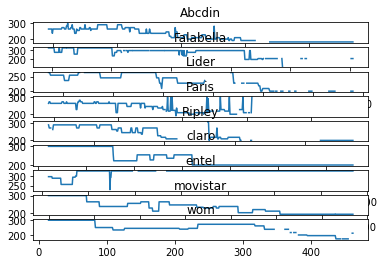

In [13]:
path = "C:/Users/Vasco/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:/Users/Vasco Costa/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:\\Users\\Tiago\\Universidade de Aveiro\Vasco Costa - AIA\\"

product_group_id = 23 #depende da pasta
time_series_folder = 1 #1,2,3

df_long, df_wide = read_files(path,product_group_id,time_series_folder)
product_information = pd.read_pickle(path+"Data/product_information")


i = 1
plt.figure()
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [14]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

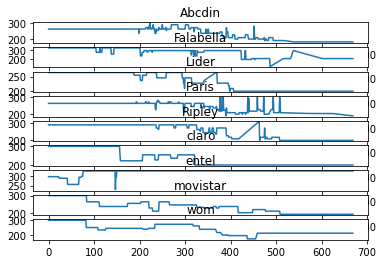

In [15]:
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")

i = 1
plt.figure()
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [16]:
company = "movistar"
raw_seq = df_wide[company]
n_steps = 1 
X, y = split_sequence(raw_seq, n_steps)
percent_train = 0.7
value = int(len(X)*percent_train)
#print(len(X))
X_train = X[:value]
#print(len(X_train))
y_train = y[:value]
X_test = X[value:]
#print(len(X_test))
y_test = y[value:]

ARIMA

In [17]:
n_features = 1
n_seq = 2
n_steps = n_steps//2


model = auto_arima(X_train, start_p=1, start_q=1,test='adf',max_p=5, max_q=5,m=1,d=1,seasonal=False,start_P=0,D=None,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2742.349, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2738.350, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2740.349, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2740.349, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2737.051, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds


In [18]:
# Forecast

prediction, confint = model.predict(n_periods=X_test.shape[0], return_conf_int=True)

prediction

prediction_train = model.predict(n_periods=raw_seq.shape[0])

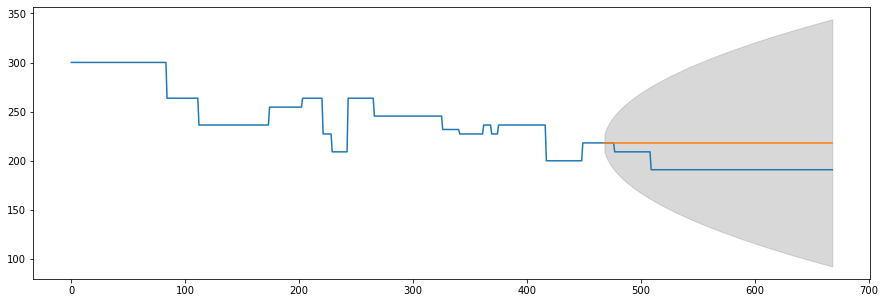

In [19]:
cf= pd.DataFrame(confint)

idx = [x for x in range(X_train.shape[0],X_train.shape[0] + X_test.shape[0],1)]

#print(idx)
prediction_series = pd.Series(prediction, index=idx)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
plt.savefig("arima_"+company+"_previsao.png",dpi=100)


#links
#https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

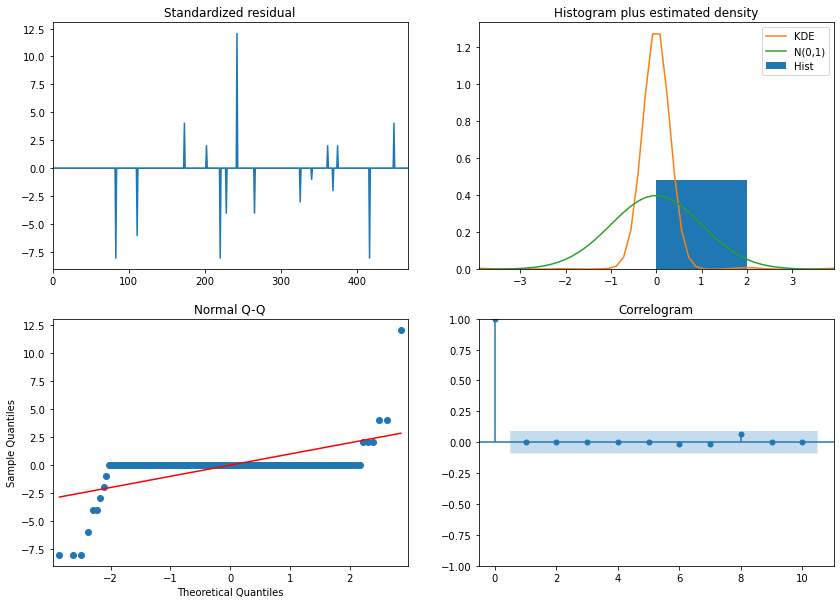

In [20]:
model.plot_diagnostics(figsize=(14,10))
plt.savefig("ARIMA_"+company+"_diagonstics.png",dpi=100)
plt.show()

In [21]:
import math
import statistics


print("train")
yhat = prediction_train[:value]
print("MAE  : ",sum(yhat - raw_seq[:value])/len(raw_seq[:value]))

#MSE
print("MSE  : ",sum((yhat - raw_seq[:value])**2)/len(raw_seq))

#NRMSE
#print("NRMSE: ",math.sqrt(sum((yhat - raw_seq)**2)/len(raw_seq))/(max(raw_seq[value:])-min(raw_seq[value:])) )
print("NRMSE: ",math.sqrt(sum((yhat - raw_seq[:value])**2)/len(raw_seq[:value]))/(statistics.mean(raw_seq[:value])) )



print("test")
#para o teste
#MAE
yhat = prediction
value1 = value+1
print("MAE  : ",sum(yhat - raw_seq[value1:])/len(raw_seq[value1:]))

#MSE
print("MSE  : ",sum((yhat - raw_seq[value1:])**2)/len(raw_seq[value1:]))

#NRMSE
#print("NRMSE: ",math.sqrt(sum((yhat - raw_seq)**2)/len(raw_seq))/(max(raw_seq[value:])-min(raw_seq[value:])) )
print("NRMSE: ",math.sqrt(sum((yhat - raw_seq[value1:])**2)/len(raw_seq[value1:]))/(statistics.mean(raw_seq[value1:])) )

train
MAE  :  -31.070665792761577
MSE  :  1258.2618249211844
NRMSE:  0.1701901129612914
test
MAE  :  23.30745979010611
MSE  :  609.7145305909081
NRMSE:  0.12662496044268504
